In [1]:
import pandas as pd
import numpy as np
import os
import re
from time import time

In [2]:
import gensim
import keras
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences


import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.preprocessing import LabelEncoder

np.random.seed(1003)

In [3]:
# Specify the folder locations
W2V_DIR = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
DATA_DIR = 'data/'

# These are some hyperparameters that can be tuned
MAX_SENT_LEN = 170
MAX_VOCAB_SIZE = 400000
LSTM_DIM = 128
EMBEDDING_DIM = 300
BATCH_SIZE = 200
N_EPOCHS = 10


In [4]:
train_bodies = pd.read_csv(DATA_DIR+'train_bodies.csv')
train_stances = pd.read_csv(DATA_DIR+'train_stances.csv')

test_bodies = pd.read_csv(DATA_DIR+'test_bodies.csv')
test_stances_unlabeled = pd.read_csv(DATA_DIR+'test_stances_unlabeled.csv')

train = train_stances.join(train_bodies.set_index('Body ID'), on='Body ID')
test = test_stances_unlabeled.join(test_bodies.set_index('Body ID'), on='Body ID')

In [5]:
train['Stance'].replace('unrelated',1,True)
train['Stance'].replace('agree',2,True)
train['Stance'].replace('disagree',3,True)
train['Stance'].replace('discuss',4,True)

word_seq_headline_train = [text_to_word_sequence(sent) for sent in train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(sent) for sent in train['articleBody']]

word_seq_headline_test = [text_to_word_sequence(sent) for sent in test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(sent) for sent in test['articleBody']]

In [6]:
word_seq = []
word_seq.extend(word_seq_headline_train)
word_seq.extend(word_seq_bodies_train)
word_seq.extend(word_seq_headline_test)
word_seq.extend(word_seq_bodies_test)


In [7]:
for i in range (len(word_seq_headline_train)):
  word_seq_headline_train[i].extend(word_seq_bodies_train[i])


for i in range (len(word_seq_headline_test)):
  word_seq_headline_test[i].extend(word_seq_bodies_test[i])

In [8]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])

In [9]:
# Convert the sequence of words to sequnce of indices
X_train = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_train])
X_train = pad_sequences(X_train, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_train = train['Stance']
y_train = y_train.values

In [10]:
from keras.utils import np_utils

encoder_train = LabelEncoder()
encoder_train.fit(y_train)
encoded_train = encoder_train.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, dummy_y_train, random_state=10, test_size=0.1)


In [12]:
EMBEDDING_DIM = 300
W2V_DIR = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
embeddings = gensim.models.KeyedVectors.load_word2vec_format(W2V_DIR, binary=True)
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

In [ ]:
X_train.shape

(44974, 170)

In [ ]:
#model Bidirectional with GRU test 1
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional, GRU
# Build a sequential model by stacking neural net units - model 1 
model_2 = Sequential()
model_2.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=True, name='word_embedding_layer' 
                          ))
model_2.add(Bidirectional(GRU(75)))

model_2.add(Dropout(0.8))
model_2.add(Dense(4, activation='sigmoid'))


In [14]:
#model Bidirectional with GRU 
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional, GRU
# Build a sequential model by stacking neural net units - model 1 
model_2 = Sequential()
model_2.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=True, name='word_embedding_layer' 
                          ))
model_2.add(Bidirectional(GRU(75),name='GRU layer'))

model_2.add(Dropout(0.8))
model_2.add(Dense(4, activation='sigmoid'))


In [ ]:
print (model_2.summary())

In [ ]:
model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model_2.fit(X_train, y_train, epochs=5,validation_data=(X_val, y_val),batch_size=32,verbose=1)

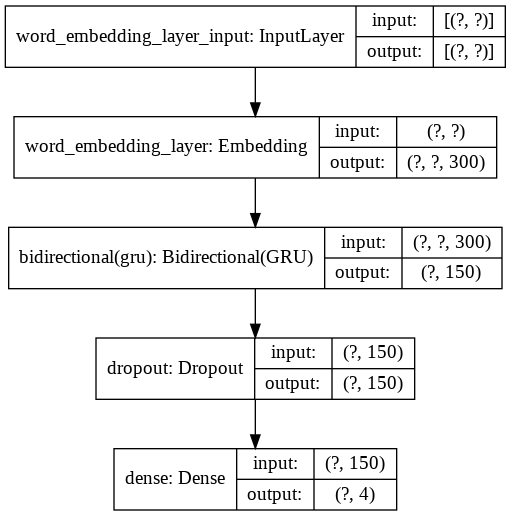

In [ ]:
from keras.utils import plot_model
plot_model(model_2, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.models import load_model

model_2.save('models/model_gru.h5')

In [ ]:
competetion_bodies = pd.read_csv(DATA_DIR+'competition_test_bodies.csv')
competetion_stances = pd.read_csv(DATA_DIR+'competition_test_stances.csv')

comp = competetion_stances.join(competetion_bodies.set_index('Body ID'), on='Body ID')

In [ ]:
comp.replace('unrelated',1,True)
comp.replace('agree',2,True)
comp.replace('disagree',3,True)
comp.replace('discuss',4,True)

In [ ]:
word_seq_headline_comp = [text_to_word_sequence(sent) for sent in comp['Headline']]
word_seq_bodies_comp = [text_to_word_sequence(sent) for sent in comp['articleBody']]


In [ ]:
for i in range (len(word_seq_headline_comp)):
  word_seq_headline_comp[i].extend(word_seq_bodies_comp[i])

In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_comp])

X_test_headline = tokenizer.texts_to_sequences(test.processed_headline)
X_test_body = tokenizer.texts_to_sequences(test.processed_body)

In [ ]:

X_comp = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_comp])
X_comp = pad_sequences(X_comp, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_comp = comp['Stance']
y_comp = y_comp.values



In [ ]:
encoder_comp = LabelEncoder()
encoder_comp.fit(y_comp)
encoded_comp = encoder_comp.transform(y_comp)
dummy_y_comp = np_utils.to_categorical(encoded_comp)

In [ ]:
y_predict = model_2.predict(X_comp)
score,test_acc = model_2.evaluate(X_comp, dummy_y_comp)
y_predict = model.predict(x=X_comp)
outputs = [np.argmax(p) for p in y_predict]
for i in range(len(outputs)):
  if outputs[i] == 0: outputs[i] = "agree"
  if outputs[i] == 1: outputs[i] = "disagree"
  if outputs[i] == 2: outputs[i] = "discuss"
  if outputs[i] == 3: outputs[i] = "unrelated"
print("Scores on the test set")
from utils.score import report_score
report_score(comp.Stance.values,x)



795/795 [==============================] - 57s 71ms/step - loss: 1.2102 - accuracy: 0.6935


In [ ]:
test_acc

0.6935033202171326

In [15]:
y_predict = model_2.predict(x=X_comp)
outputs = [np.argmax(p) for p in y_predict]
for i in range(len(outputs)):
  if outputs[i] == 0: outputs[i] = "agree"
  if outputs[i] == 1: outputs[i] = "disagree"
  if outputs[i] == 2: outputs[i] = "discuss"
  if outputs[i] == 3: outputs[i] = "unrelated"
print("Scores on the test set")
from utils.score import report_score
report_score(comp.Stance.values,outputs)
